In [24]:
# Import necessary libraries.
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

In [3]:
# Data comes form https://www.transtats.bts.gov/Tables.asp.

# Path to CSV files. All flights are within the US.
metadata_csv_file_path = "db1b-2024-q1/coupon-metadata.csv"
fare_csv_file_path = "db1b-2024-q1/coupon-fare.csv"

# Read CSVs into a DataFrames using pandas.
metadata = pd.read_csv(metadata_csv_file_path)
fare = pd.read_csv(fare_csv_file_path)

In [13]:
# Merge metadata and fare DataFrames on ItinID.
metadata_and_fares_df = pd.merge(
    metadata[["ItinID", "OriginStateName", "DestStateName", "FareClass", "Passengers"]],
    # Single person fare per itinerary. There are no duplicate ItinID in the fare table.
    fare[["ItinID", "ItinFare"]],
    on="ItinID",
    how="inner",
).rename(
    columns={
        "ItinFare": "per_passenger_fare",
        "Passengers": "passengers_count",
        "FareClass": "fare_class",
        "OriginStateName": "origin_state_name",
        "DestStateName": "destination_state_name",
    }
)

In [15]:
# Human-readable formatting of FareClass. The FareClass column contains the following values:
# Fare Class	Meaning
# -	            Ground Segment
# C	            Unrestricted Business Class
# D	            Restricted Business Class
# F	            Unrestricted First Class
# G         	Restricted First Class
# U         	Unknown
# X         	Restricted Coach Class
# Y	            Unrestricted Coach Class
def coarse_fare_class(fare_class: str) -> str:
    match fare_class:
        case "F":
            return "First"
        case "G":
            return "First"
        case "C":
            return "Business"
        case "D":
            return "Business"
        case "X":
            return "Coach"
        case "Y":
            return "Coach"
        case _:
            return "Unknown"


metadata_and_fares_df.fare_class = metadata_and_fares_df.fare_class.apply(
    coarse_fare_class
)

In [26]:
# Keep only those rows where state names match.
def filter_by_state_of_origin_and_destination(
    df: pd.DataFrame, state_names: List[str]
) -> pd.DataFrame:
    if len(state_names) != 2:
        raise ValueError("state_names must contain exactly two state names.")

    origin_to_destination_set = (df.origin_state_name == state_names[0]) & (
        df.destination_state_name == state_names[1]
    )

    destination_to_origin_set = (df.origin_state_name == state_names[1]) & (
        df.destination_state_name == state_names[0]
    )
    return df[origin_to_destination_set | destination_to_origin_set][
        ["per_passenger_fare", "passengers_count", "fare_class"]
    ]

In [27]:
# Choose frequent business & leisure routes to simplify the analysis.
long_haul = filter_by_state_of_origin_and_destination(
    metadata_and_fares_df, ["New York", "California"]
)

short_haul = filter_by_state_of_origin_and_destination(
    metadata_and_fares_df, ["New York", "Washington"]
)

In [28]:
# Number of passengers per fare_class sit fare.
def passengers_per_fare_class_sit_fare(
    df: pd.DataFrame, fare_class: str
) -> pd.DataFrame:
    return (
        df[df.fare_class == fare_class]
        .groupby("per_passenger_fare")
        .agg(total_passengers=("passengers_count", "sum"))
        .reset_index()
    )

In [30]:
# Number of passengers per fare_class sit fare.
long_haul_passengers_per_coach_fare = passengers_per_fare_class_sit_fare(long_haul, "Coach")
long_haul_passengers_per_business_fare = passengers_per_fare_class_sit_fare(long_haul, "Business")

short_haul_passengers_per_coach_fare = passengers_per_fare_class_sit_fare(short_haul, "Coach")
short_haul_passengers_per_business_fare = passengers_per_fare_class_sit_fare(short_haul, "Business")

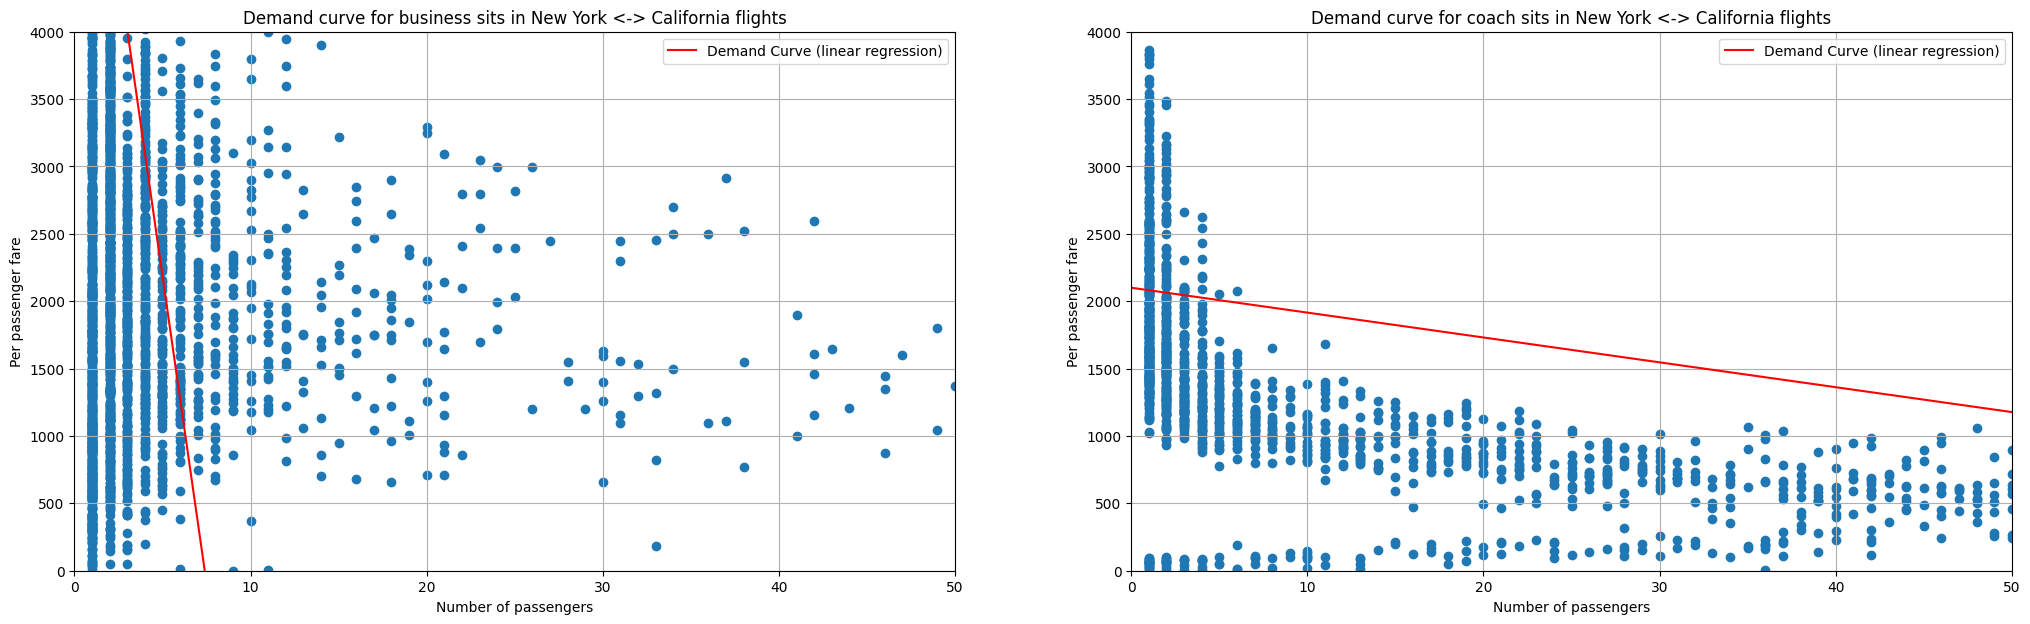

In [32]:
plt.figure(figsize=(25, 7))

plt.subplot(1, 2, 1)
plt.scatter(
    long_haul_passengers_per_business_fare.total_passengers,
    long_haul_passengers_per_business_fare.per_passenger_fare,
)

z = np.polyfit(
    long_haul_passengers_per_business_fare.per_passenger_fare,  # x
    long_haul_passengers_per_business_fare.total_passengers,  # y
    1,
)

p = np.poly1d(z)

plt.plot(
    p(long_haul_passengers_per_business_fare.per_passenger_fare),
    long_haul_passengers_per_business_fare.per_passenger_fare,
    color="red",
    label="Demand Curve (linear regression)",
)

plt.xlabel("Number of passengers")
plt.xlim(0, 50)
plt.ylabel("Per passenger fare")
plt.ylim(0, 4000)
plt.grid(True)
plt.title("Demand curve for business sits in New York <-> California flights")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(
    long_haul_passengers_per_coach_fare.total_passengers,
    long_haul_passengers_per_coach_fare.per_passenger_fare,
)

z = np.polyfit(
    long_haul_passengers_per_coach_fare.per_passenger_fare,  # x
    long_haul_passengers_per_coach_fare.total_passengers,  # y
    1,
)

p = np.poly1d(z)

plt.plot(
    p(long_haul_passengers_per_coach_fare.per_passenger_fare),
    long_haul_passengers_per_coach_fare.per_passenger_fare,
    color="red",
    label="Demand Curve (linear regression)",
)

plt.xlabel("Number of passengers")
plt.xlim(0, 50)
plt.ylabel("Per passenger fare")
plt.ylim(0, 4000)
plt.grid(True)
plt.title("Demand curve for coach sits in New York <-> California flights")
plt.legend()

plt.show()

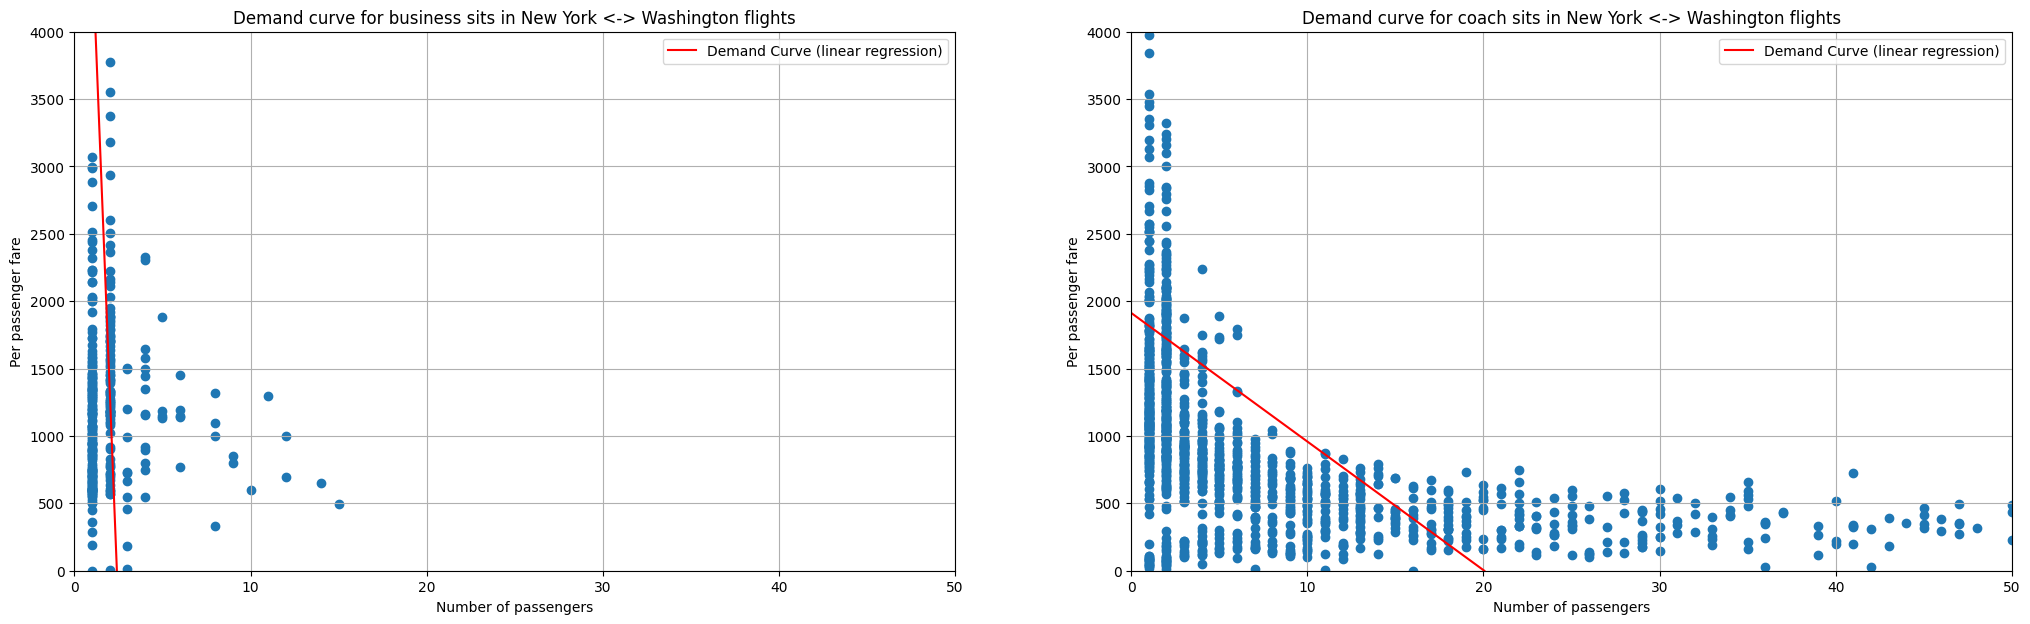

In [33]:
plt.figure(figsize=(25, 7))

plt.subplot(1, 2, 1)
plt.scatter(
    short_haul_passengers_per_business_fare.total_passengers,
    short_haul_passengers_per_business_fare.per_passenger_fare,
)

z = np.polyfit(
    short_haul_passengers_per_business_fare.per_passenger_fare,  # x
    short_haul_passengers_per_business_fare.total_passengers,  # y
    1,
)

p = np.poly1d(z)

plt.plot(
    p(short_haul_passengers_per_business_fare.per_passenger_fare),
    short_haul_passengers_per_business_fare.per_passenger_fare,
    color="red",
    label="Demand Curve (linear regression)",
)

plt.xlabel("Number of passengers")
plt.xlim(0, 50)
plt.ylabel("Per passenger fare")
plt.ylim(0, 4000)
plt.grid(True)
plt.title("Demand curve for business sits in New York <-> Washington flights")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(
    short_haul_passengers_per_coach_fare.total_passengers,
    short_haul_passengers_per_coach_fare.per_passenger_fare,
)

z = np.polyfit(
    short_haul_passengers_per_coach_fare.per_passenger_fare,  # x
    short_haul_passengers_per_coach_fare.total_passengers,  # y
    1,
)

p = np.poly1d(z)

plt.plot(
    p(short_haul_passengers_per_coach_fare.per_passenger_fare),
    short_haul_passengers_per_coach_fare.per_passenger_fare,
    color="red",
    label="Demand Curve (linear regression)",
)

plt.xlabel("Number of passengers")
plt.xlim(0, 50)
plt.ylabel("Per passenger fare")
plt.ylim(0, 4000)
plt.grid(True)
plt.title("Demand curve for coach sits in New York <-> Washington flights")
plt.legend()

plt.show()

Given the graphs above, it's clear business class passengers are more inelastic (left graph) than economy/coach passengers (right graph).
- The inferred demand curve is almost vertical for business class passengers, which indicates that (almost) regardless of the price there will always be the same demand.
- However, the inferred demand curve for economy/coach passengers if much flatter, indicating that a slight reduction in price can result in a significant increase in demand.

In [ ]:
# TODO : Given the demand curves, calculate their elasticity, and plot the different regions (elastic, unit elastic, inelastic).

# TODO : What if you go from Washington DC to New York? Does elasticity change when there are options (e.g. there is a train that goes from Washington DC to New York)?